Link: https://www.earthdatascience.org/courses/use-data-open-source-python/intro-vector-data-python/vector-data-processing/dissolve-polygons-in-python-geopandas-shapely/

In [1]:
# Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap
import seaborn as sns
from shapely.geometry import box
import geopandas as gpd
import earthpy as et

# Adjust plot font sizes
sns.set(font_scale=1.5)
sns.set_style("white")

# Set working dir & get data
data = et.data.get_data('spatial-vector-lidar')
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

In [2]:
# Define base path as it is repeated below
base_path = os.path.join("data", "spatial-vector-lidar")

# Define file paths
country_boundary_path = os.path.join(base_path, "usa", 
                                     "usa-boundary-dissolved.shp")

state_boundary_path = os.path.join(base_path, "usa", 
                                   "usa-states-census-2014.shp")

pop_places_path = os.path.join(base_path, "global", "ne_110m_populated_places_simple", 
                               "ne_110m_populated_places_simple.shp")

# Import the data
country_boundary_us = gpd.read_file(country_boundary_path)
state_boundary_us = gpd.read_file(state_boundary_path)
pop_places = gpd.read_file(pop_places_path)

In [3]:
state_boundary_us.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,region,geometry
0,06,01779778,0400000US06,06,CA,California,00,403483823181,20483271881,West,"MULTIPOLYGON Z (((-118.59397 33.46720 0.00000,..."
1,11,01702382,0400000US11,11,DC,District of Columbia,00,158350578,18633500,Northeast,"POLYGON Z ((-77.11976 38.93434 0.00000, -77.04..."
2,12,00294478,0400000US12,12,FL,Florida,00,138903200855,31407883551,Southeast,"MULTIPOLYGON Z (((-81.81169 24.56874 0.00000, ..."
3,13,01705317,0400000US13,13,GA,Georgia,00,148963503399,4947080103,Southeast,"POLYGON Z ((-85.60516 34.98468 0.00000, -85.47..."
4,16,01779783,0400000US16,16,ID,Idaho,00,214045425549,2397728105,West,"POLYGON Z ((-117.24303 44.39097 0.00000, -117...."


In [4]:
state_boundary_us.geom_type.head()

0    MultiPolygon
1         Polygon
2    MultiPolygon
3         Polygon
4         Polygon
dtype: object

In [5]:
state_boundary = state_boundary_us[['LSAD', 'geometry']]
cont_usa = state_boundary.dissolve(by='LSAD')

# View the resulting geodataframe
cont_usa

,geometry
LSAD,
00,"MULTIPOLYGON Z (((-81.81169 24.56874 0.00000, ..."


In [6]:
cont_usa.reset_index()

,LSAD,geometry
0,00,"MULTIPOLYGON Z (((-81.81169 24.56874 0.00000, ..."


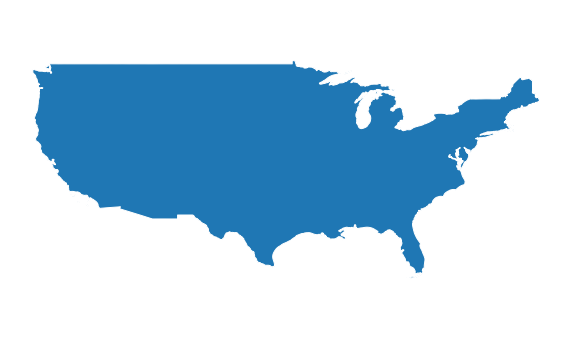

In [7]:
# Plot the data
fig, ax = plt.subplots(figsize=(10, 6))
cont_usa.reset_index().plot(column='LSAD',
                            ax=ax)
ax.set_axis_off()
plt.axis('equal')
plt.show() 

In [8]:
# Select the columns that you wish to retain in the data
state_boundary = state_boundary_us[['region', 'geometry', 'ALAND', 'AWATER']]

# Then summarize the quantative columns by 'sum'
regions_agg = state_boundary.dissolve(by='region', aggfunc='sum')
regions_agg

,geometry,ALAND,AWATER
region,,,
Midwest,"MULTIPOLYGON Z (((-87.80048 42.49192 0.00000, ...",1943869253244,184383393833
Northeast,"MULTIPOLYGON Z (((-76.04621 38.02553 0.00000, ...",869066138232,108922434345
Southeast,"MULTIPOLYGON Z (((-81.81169 24.56874 0.00000, ...",1364632039655,103876652998
Southwest,"POLYGON Z ((-94.48587 33.63787 0.00000, -94.41...",1462631530997,24217682268
West,"MULTIPOLYGON Z (((-104.05325 41.00141 0.00000,...",2432336444730,57568049509


In [9]:
# Convert area units from square meters to hectares (divide by 10,000)
regions_agg["land_ha"] = regions_agg["ALAND"] / 10000
regions_agg["water_ha"] = regions_agg["AWATER"] / 10000
regions_agg

,geometry,ALAND,AWATER,land_ha,water_ha
region,,,,,
Midwest,"MULTIPOLYGON Z (((-87.80048 42.49192 0.00000, ...",1943869253244,184383393833,1.943869e+08,1.843834e+07
Northeast,"MULTIPOLYGON Z (((-76.04621 38.02553 0.00000, ...",869066138232,108922434345,8.690661e+07,1.089224e+07
Southeast,"MULTIPOLYGON Z (((-81.81169 24.56874 0.00000, ...",1364632039655,103876652998,1.364632e+08,1.038767e+07
Southwest,"POLYGON Z ((-94.48587 33.63787 0.00000, -94.41...",1462631530997,24217682268,1.462632e+08,2.421768e+06
West,"MULTIPOLYGON Z (((-104.05325 41.00141 0.00000,...",2432336444730,57568049509,2.432336e+08,5.756805e+06


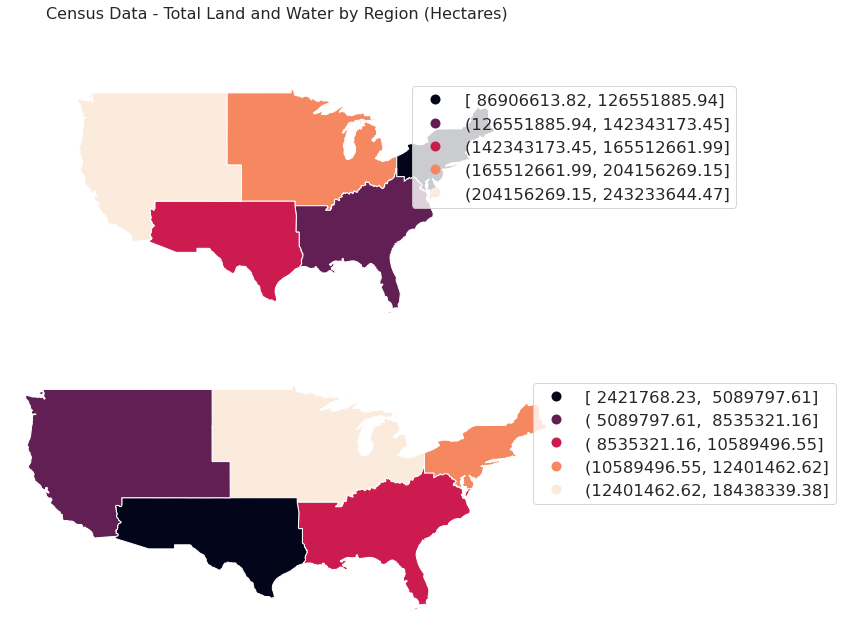

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

regions_agg.plot(column='land_ha',
                 legend=True,
                 scheme="quantiles",
                 ax=ax1)

regions_agg.plot(column='water_ha',
                 scheme="quantiles",
                 legend=True,
                 ax=ax2)

plt.suptitle('Census Data - Total Land and Water by Region (Hectares)', fontsize=16)
leg = ax1.get_legend()
leg.set_bbox_to_anchor((1.5,1))

leg = ax2.get_legend()
leg.set_bbox_to_anchor((1.5,1))
ax1.set_axis_off()
ax2.set_axis_off()

plt.axis('equal')
plt.show()